# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [2]:
# Basic imports.
import os
import time
import numpy as np
import torch

from torch.autograd import Variable
import torch.nn.functional as F

from torch import nn
from torch import optim

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

## Casting para o dispositivo correto

Como usaremos processamento vetorial principalmente em GPUs para aprendizado profundo, primeiramente é possível verificar se há uma GPU disponível com o trecho de código abaixo, armazenando os tensores nos dispositivos apropriados.

In [3]:
# Checking if GPU/CUDA is available.
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


# Intro MLP

## Neurônios e a camada `nn.Linear`

A camada Linear do Pytorch ([nn.Linear](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)) é responsável por aplicar uma transformação linear no dado de entrada. Esta camada recebe como parâmetro a dimensão (número de *features*) da entrada e da saída (que na verdade, representa o número de neurônios dessa camada). Por padrão o bias já é incluído. **Um** perceptron pode ser facilmente representado como a seguir, desconsiderando a função de ativação:

```
linear = nn.Linear(in_dimension, 1)
```
Mas de uma forma geral, uma camada Linear com diversas *features* de entrada e diversas *features* de saída pode ser representada como:
```
nn.Linear(in_features, out_features)
```
![](https://github.com/flaviovdf/deep-ufmg/blob/main/listas/figs/nn_linear.png?raw=1)

In [4]:
linear = nn.Linear(2, 1)
print(linear)

Linear(in_features=2, out_features=1, bias=True)


Como é possível ver no código abaixo, o Pytorch já inicia os pesos da camada aleatoriamente.

In [5]:
for param in linear.parameters():
  print(param)

Parameter containing:
tensor([[0.2690, 0.5329]], requires_grad=True)
Parameter containing:
tensor([-0.0796], requires_grad=True)


O **forward** consiste em passar seu dado de entrada pela rede, gerando um resultado ao final. Considerando a camada linear instanciada anteriormente, o resultado do forward é o mesmo do somatório da multiplicação de seus pesos pelas respectivas entradas juntamente com o bias, ou seja:

$$f_w(x) = w_0 + w_1x_1 + w_2x_2 + \ldots + w_nx_n$$

No Pytorch, realizamos o **forward** chamando o objeto onde nossa rede/modelo está instanciada, conforme exemplo abaixo.

In [6]:
linear = nn.Linear(2, 1)
X = torch.tensor([2.0, 3.0]) # dado de entrada de exemplo considerando o perceptron definido como nn.Linear(2,1)
print('Pytorch: ', linear(X))

# acessamos os pesos do modelo com .weight e o bias com .bias
print('Manual: ', torch.sum(X * linear.weight) + linear.bias)

Pytorch:  tensor([-1.0603], grad_fn=<ViewBackward0>)
Manual:  tensor([-1.0603], grad_fn=<AddBackward0>)


In [8]:
# Ao fazermos linear(X), estamos fazendo implicitamente uma chamada na função forward da Linear
print('Forward com chamada implícita:', linear(X))
print('Forward com chamada explícita:', linear.forward(X))

Forward com chamada implícita: tensor([-1.0603], grad_fn=<ViewBackward0>)
Forward com chamada explícita: tensor([-1.0603], grad_fn=<ViewBackward0>)


## Exemplo de uma rede neural simples (1 camada)

O código abaixo cria uma rede neural simples usando `nn.Linear` e implementa o fluxo de treinamento para essa rede, ou seja, faz o forward, calcula a loss, e otimiza seus pesos. Invista um pouco de tempo para entender a célula abaixo pois usaremos essa ideia para implementar a função de treino mais a frente.

In [9]:
# Iremos criar dados que seguem a função y = 2x + 3
dataset = []
for x in range(10):
    dataset.append((x, 2*x + 3)) # tupla com (x, y)

In [10]:
dataset

[(0, 3),
 (1, 5),
 (2, 7),
 (3, 9),
 (4, 11),
 (5, 13),
 (6, 15),
 (7, 17),
 (8, 19),
 (9, 21)]

In [11]:
# Definiremos uma loss (erro quadrático -> (y - y_hat)^2)
def loss_fn(predict, label):
    return torch.pow(label - predict, 2)

In [12]:
linear = nn.Linear(1, 1) # Camada linear com 1 feature de entrada (mais o bias) e uma de saída
linear.to(device) # casting do linear para GPU

learning_rate = 0.01
print(f'Parâmetros iniciais: {list(linear.parameters())}\n')

for epoch in range(100):
    epoch_loss = 0

    for X, y in dataset:
        # Fazendo o casting dos dados para tensores na GPU
        X = torch.FloatTensor([X]).to(device)
        y = torch.FloatTensor([y]).to(device)

        y_pred = linear(X)  # etapa de forward
        loss = loss_fn(y_pred, y)  # calcula a loss
        epoch_loss += loss.item()

        # Etapa de backprop
        loss.backward()
        with torch.no_grad(): # não queremos fazer com que o pytorch anote as operações do backprop e acumule o gradiente
            for param in linear.parameters():
                param -= learning_rate * param.grad  # atualização dos parametros (pesos e bias) com base no gradiente
                param.grad.zero_()  # resetando o gradiente

    if (epoch + 1) % 10 == 0:
        print("Epoch {} - loss: {}".format(epoch + 1, epoch_loss))

print('\nParâmetros finais: ', list(linear.parameters()))

Parâmetros iniciais: [Parameter containing:
tensor([[0.4472]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.4195], device='cuda:0', requires_grad=True)]

Epoch 10 - loss: 4.505959912203252
Epoch 20 - loss: 1.5572157478891313
Epoch 30 - loss: 0.53815991000738
Epoch 40 - loss: 0.18598417562316172
Epoch 50 - loss: 0.06427494043600745
Epoch 60 - loss: 0.02221234102762537
Epoch 70 - loss: 0.007676252965211461
Epoch 80 - loss: 0.002652884471899597
Epoch 90 - loss: 0.000916688311008329
Epoch 100 - loss: 0.00031678091545472853

Parâmetros finais:  [Parameter containing:
tensor([[2.0011]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([2.9897], device='cuda:0', requires_grad=True)]


In [13]:
X = torch.FloatTensor([20]).to(device)
print(linear(X)) # forward do valor 20 para conferir resultado, saida deve ser aproximadamente = 2x+3 = 2*20+3 = 43

tensor([43.0114], device='cuda:0', grad_fn=<ViewBackward0>)


## O módulo `nn.Sequential`

Na prática, criaremos redes com diversas camadas. O bloco `nn.Sequential` permite agrupar as camadas de forma sequencial para que o forward seja realizado na ordem desejada. Veja um exemplo para um *Multilayer Perceptron (MLP)* abaixo.

In [15]:
in_features = 28
out_features = 8

first_hidden_size = 64
second_hidden_size = 32

MLP = nn.Sequential(
    nn.Linear(in_features, first_hidden_size), nn.ReLU(),
    nn.Linear(first_hidden_size, second_hidden_size), nn.ReLU(),
    nn.Linear(second_hidden_size, out_features)
)

print(MLP)

Sequential(
  (0): Linear(in_features=28, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=8, bias=True)
)


In [16]:
test_data = torch.randn((10, 28)) # 10 dados de input aleatórios com 28 features

output = MLP(test_data) # forward da rede
print(output.size())

torch.Size([10, 8])


Informação sobre outras camadas lineares, como nn.Bilinear e nn.Identity, podem ser vistas na documentação: https://pytorch.org/docs/stable/nn.html#linear-layers

## Conjunto de Exercícios 1 - Implementação de uma MLP

Vamos agora treinar um MLP simples no dataset de [Breast Cancer da UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). A célula abaixo irá carregar os dados utilizando a biblioteca scikit-learn, que já possui o dataset pronto para utilizarmos.

- Neste exercício, não estamos interessados em trabalhar com dados de treino/teste, mas sim apenas estudar como definir uma rede neural de múltiplas camadas em PyTorch e realizar o treinamento dos seus pesos e viéses.

In [17]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)

# Convertendo os dados para tensores PyTorch e fazendo o casting para o dispositivo apropriado
X = torch.FloatTensor(X).to(device)
y = torch.FloatTensor(y).to(device)

# Modificando o shape das anotações para ser um vetor (n, 1) para não gerar erros no cálculo da função de perda
# Isso é necessário pois os produtos internos feitos no PyTorch irá resultar em uma matriz (n, 1), ou seja, n-linhas
# onde cada linha terá um valor binário (classe daquela observação)
y = y.reshape(y.shape[0], 1)

# Exibindo o tamanho dos tensores
print('Tamanho de X: ', X.size())
print('Tamanho de y: ', y.size())

Tamanho de X:  torch.Size([569, 30])
Tamanho de y:  torch.Size([569, 1])


In [18]:
print('Labels dos dados:', torch.unique(y))

Labels dos dados: tensor([0., 1.], device='cuda:0')


1. Implemente na célula abaixo uma MLP, de nome **model**, utilizando o módulo `nn.Sequential`. A sua rede MLP deve possuir, pelo menos, uma camada escondida, usando uma ReLU como função de ativação entre as camadas.

    - Note que o nosso problema é um problema de classificação binária. Iremos utilizar uma função de perda do PyTorch que recebe como entrada a saída "crua" (*logits*) da sua rede neural. Sendo assim, não se preocupe em aplicar alguma transformação na saída (como uma sigmóide) para converter os valores para uma probabilidade, por exemplo.

In [19]:
in_features = 30
out_features = 1

first_hidden_size = 64
second_hidden_size = 32
third_hidden_size = 16

model = nn.Sequential(
    nn.Linear(in_features, first_hidden_size), nn.ReLU(),
    nn.Linear(first_hidden_size, second_hidden_size), nn.ReLU(),
    nn.Linear(second_hidden_size, third_hidden_size), nn.ReLU(),
    nn.Linear(third_hidden_size, out_features)
)

model.to(device)  # sempre é necessario fazer o casting da rede para jogá-la para GPU
print(model)


Sequential(
  (0): Linear(in_features=30, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=1, bias=True)
)


Abaixo, definimos uma loss e um otimizador usando o PyTorch. Não se preocupem como isso funciona agora, pois iremos ver em detalhes como definir e usar diferentes losses e otimizadores com o PyTorch.

In [20]:
# Iremos utilizar a entropia cruzada binária como função de perda para o nosso problema
# Essa versão da BCE aceita como entrada a saída "crua" (logits) da sua rede neural.
# Outras versões, como a BCELoss aceita como entrada uma saída probabilística da sua rede neural (sigmoid ou softmax),
# sendo assim você deve colocar uma função de ativação depois do último nn.Linear do seu modelo.
# A versão BCEWithLogitsLoss implementa uma versão mais numericamente estável da loss, podemos observar isso na própria
# documentação do PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html?highlight=bcewithlogitsloss#torch.nn.BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

In [21]:
# Iremos utilizar o pacote optim para definir um otimizador que irá atualizar os pesos do modelo para nós.
# Aqui, utilizaremos SGD - Gradiente Descendente Estocástico.
# O pacote optim contém muitos outros algoritmos de otimização, porém, em todos o primeiro parâmetro irá dizer para os
# otimizadores quais tensores (com requires_grad=True) do nosso modelo ele deverá otimizar.
import torch.optim as optim

learning_rate = 1e-4
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Abaixo teremos um loop de treinamento típico de PyTorch. Não precisa modificar em nada essa funçao, porém estude ela mesmo assim, já que usaremos esse fluxo como template para treinamento de outros modelos mais a frente no curso.

In [22]:
# Aqui iremos criar uma lista de loss para cada época
loss_list = []

# Iterando sobre as épocas
n_epochs = 500
for epoch in range(n_epochs):
    preds = model(X)
    loss = criterion(preds, y)

    # Salvando a loss da iteração atual (para plots futuros)
    loss_list.append(loss.item())

    # Antes de fazermos o backward pass, iremos zerar o gradiente de todos os tensores
    # atrelados ao otimizador utilizando a chamada de função .zero_grad() do nosso otimizador.
    # Faremos isso pois os gradientes são acumulados, sempre que chamamos .backward(), em buffers nos
    # tensores que representam os pesos dos nossos modelos, ou seja, não são sobrescritos.
    # Para mais detalhes, você pode dar uma olhada na documentação do torch.autograd.backward
    optimizer.zero_grad()

    # Realizando o backward pass, ou seja, computando os gradientes da nossa função de perda
    # com respeito aos parâmetros (pesos) do nosso modelo
    loss.backward()

    # Chamando a função .step() do nosso otimizador para realizar um "passo" na otimização.
    # Nesse caso, o "passo" será realizar o cálculo que vimos do gradiente descendente
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}: loss = {loss.item():.5f}')

Epoch 10: loss = 0.96544
Epoch 20: loss = 0.64332
Epoch 30: loss = 0.58063
Epoch 40: loss = 0.54862
Epoch 50: loss = 0.50498
Epoch 60: loss = 0.47307
Epoch 70: loss = 0.46070
Epoch 80: loss = 0.44465
Epoch 90: loss = 0.43247
Epoch 100: loss = 0.42835
Epoch 110: loss = 0.42495
Epoch 120: loss = 0.42179
Epoch 130: loss = 0.41881
Epoch 140: loss = 0.41602
Epoch 150: loss = 0.41336
Epoch 160: loss = 0.41080
Epoch 170: loss = 0.40831
Epoch 180: loss = 0.40589
Epoch 190: loss = 0.40357
Epoch 200: loss = 0.40130
Epoch 210: loss = 0.39906
Epoch 220: loss = 0.39686
Epoch 230: loss = 0.39469
Epoch 240: loss = 0.39256
Epoch 250: loss = 0.39049
Epoch 260: loss = 0.38844
Epoch 270: loss = 0.38644
Epoch 280: loss = 0.38444
Epoch 290: loss = 0.38243
Epoch 300: loss = 0.38045
Epoch 310: loss = 0.37849
Epoch 320: loss = 0.37653
Epoch 330: loss = 0.37460
Epoch 340: loss = 0.37270
Epoch 350: loss = 0.37077
Epoch 360: loss = 0.36889
Epoch 370: loss = 0.36702
Epoch 380: loss = 0.36514
Epoch 390: loss = 0.3

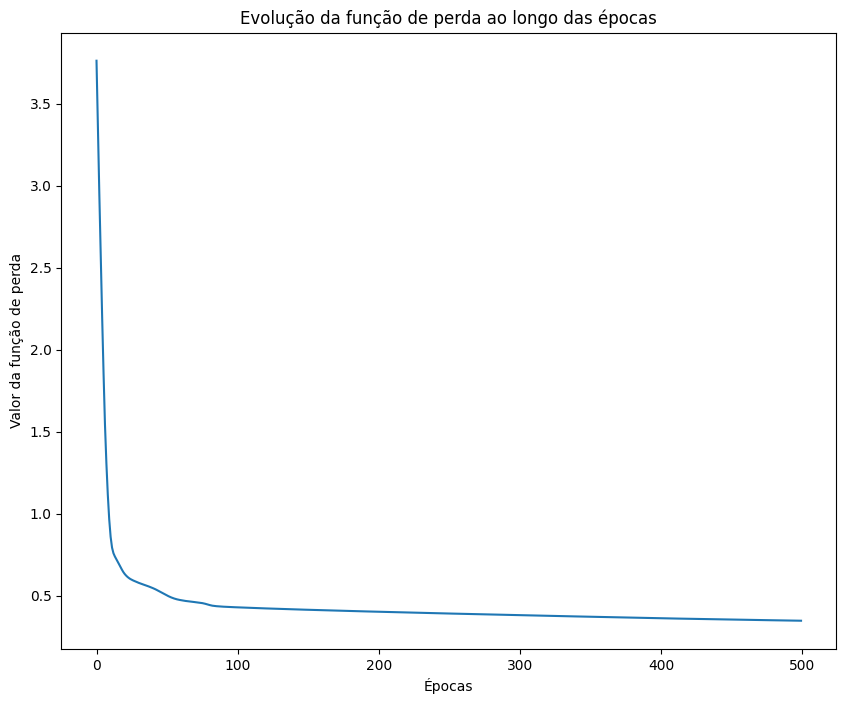

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.set_title('Evolução da função de perda ao longo das épocas')
ax.set_ylabel('Valor da função de perda')
ax.set_xlabel('Épocas')
ax.plot(np.asarray(loss_list))

plt.show()